In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
pd.set_option('future.no_silent_downcasting', True)

In [3]:
path = "./comodity-price-prediction-penyisihan-arkavidia-9/Harga Bahan Pangan/"
path_train = np.sort(os.listdir(path + "train"))
path_test = np.sort(os.listdir(path + "test"))

In [4]:
path_train

array(['Bawang Merah.csv', 'Bawang Putih Bonggol.csv', 'Beras Medium.csv',
       'Beras Premium.csv', 'Cabai Merah Keriting.csv',
       'Cabai Rawit Merah.csv', 'Daging Ayam Ras.csv',
       'Daging Sapi Murni.csv', 'Gula Konsumsi.csv',
       'Minyak Goreng Curah.csv', 'Minyak Goreng Kemasan Sederhana.csv',
       'Telur Ayam Ras.csv', 'Tepung Terigu (Curah).csv'], dtype='<U35')

In [5]:
path_train[0]

'Bawang Merah.csv'

In [6]:
df_train = [pd.read_csv(path + "train/" + data) for data in path_train]

for i, df_pangan in enumerate(df_train):
    df_pangan["Pangan"] = path_train[i].replace(".csv", "")

df_train = pd.concat(df_train, axis=0, ignore_index=True)
df_train["Date"] = pd.to_datetime(df_train["Date"])
df_train = df_train.set_index("Date")

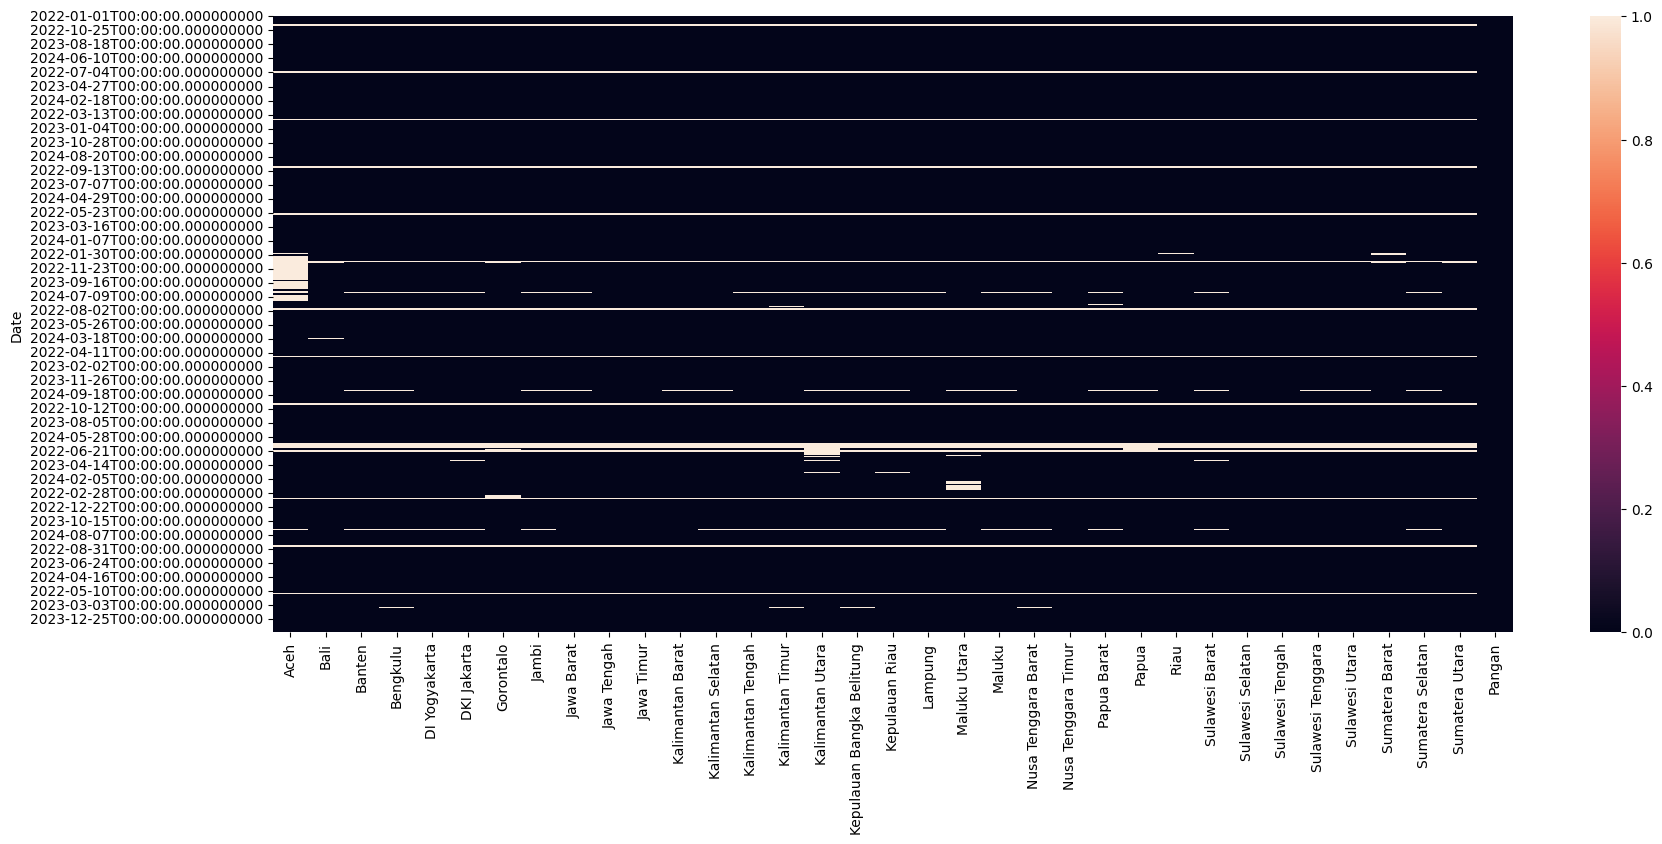

In [7]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(df_train.isna(), ax=ax);

In [8]:
list_provinsi = df_train.columns[:-1].to_list()

<Axes: xlabel='Date'>

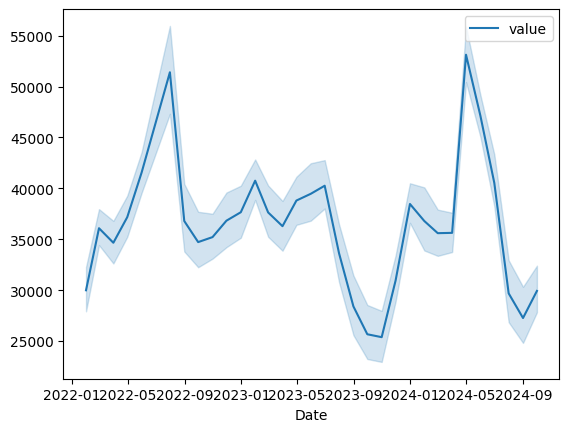

In [9]:
bawang_merah = df_train.loc[df_train["Pangan"] == "Bawang Merah", list_provinsi].asfreq("ME").T.melt().set_index("Date")
sns.lineplot(bawang_merah)

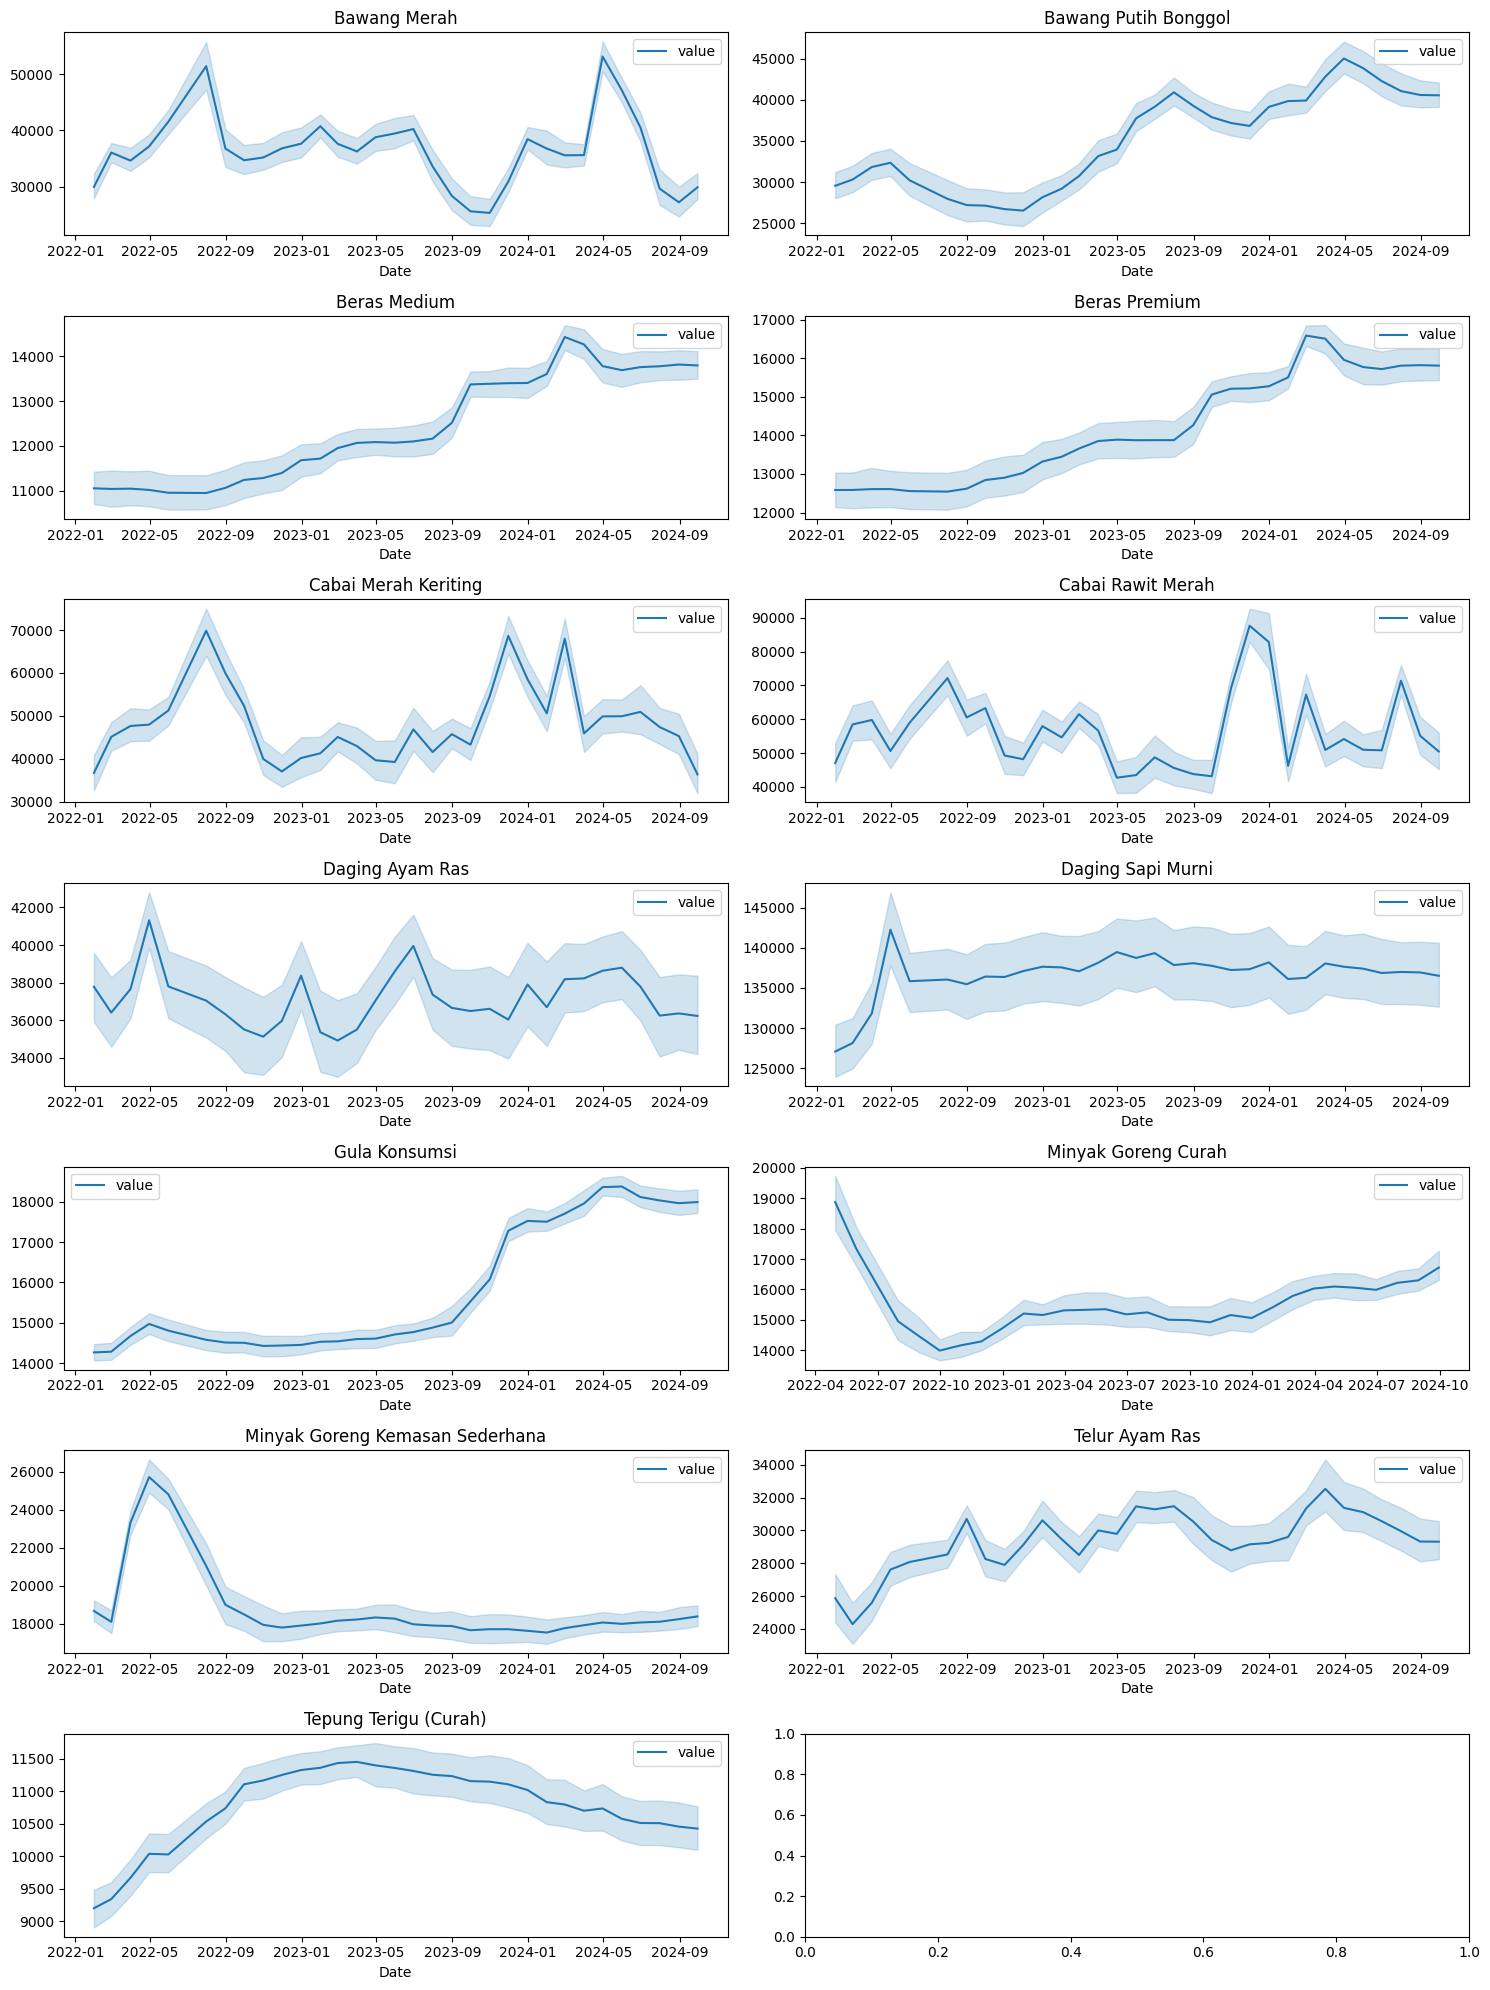

In [10]:
bahan_pangan = df_train["Pangan"].unique()

fig, ax = plt.subplots(int(len(bahan_pangan)/2) + 1, 2, figsize=(15, 20))
ax = ax.flatten()

for i, pangan in enumerate(bahan_pangan):
    groupby_pangan = df_train.loc[df_train["Pangan"] == pangan, list_provinsi].asfreq("ME").T.melt().set_index("Date")
    sns.lineplot(groupby_pangan, ax=ax[i])
    ax[i].title.set_text(pangan)
    
plt.tight_layout()

In [11]:
import xgboost as xgb
import copy
from sklearn.impute import KNNImputer

In [12]:
for pangan in bahan_pangan:
    pangan_df = df_train[df_train["Pangan"] == pangan]
    for prov in list_provinsi:
        df_train.loc[df_train["Pangan"] == pangan, prov] = df_train.loc[df_train["Pangan"] == pangan, prov].interpolate(method="time")
        df_train.loc[df_train["Pangan"] == pangan, prov] = df_train.loc[df_train["Pangan"] == pangan, prov].bfill()
        df_train.loc[df_train["Pangan"] == pangan, prov] = df_train.loc[df_train["Pangan"] == pangan, prov].ffill()
        df_train.loc[df_train["Pangan"] == pangan, prov] = df_train.loc[df_train["Pangan"] == pangan, prov].round(-1)
        

In [13]:
# model_xgb = xgb.XGBRegressor(n_estimators=50, learning_rate=0.1)

# for pangan in bahan_pangan:
#     pangan_df = df_train[df_train["Pangan"] == pangan]
#     pangan_df = pangan_df.drop(columns=["Pangan"])
#     for prov in list_provinsi:
#         train_data = pangan_df.dropna()
#         test_data = pangan_df[pangan_df[prov].isna()]
#         test_data = test_data.drop(columns=[prov])
    
#         train_x = train_data.drop(columns=[prov])
#         train_y = train_data[prov]

#         model_xgb.fit(train_x, train_y)

#         missing_pred = model_xgb.predict(test_data)
        
#         df_train.loc[(df_train["Pangan"] == pangan) & (df_train[prov].isna()), prov] = missing_pred

In [14]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error
import logging
from sklearn.preprocessing import MinMaxScaler

In [15]:
df_train = df_train.reset_index().rename(columns={"Date":"ds"})

In [16]:
path_commodity = "./comodity-price-prediction-penyisihan-arkavidia-9/Global Commodity Price/"
path_commodity_list = os.listdir(path_commodity)

commodity_df = [pd.read_csv(path_commodity + path)[["Date","Price"]].sort_values("Date") for path in path_commodity_list] 

for i, df_commodity in enumerate(commodity_df):
    df_commodity["Commodity"] = path_commodity_list[i].replace(".csv", "")

rename_commodity = {"Crude Oil WTI Futures Historical Data" : 1, 
                    "Natural Gas Futures Historical Data" : 2, 
                    "Newcastle Coal Futures Historical Data" : 3, 
                    "Palm Oil Futures Historical Data" : 4, 
                    "US Sugar 11 Futures Historical Data" : 5, 
                    "US Wheat Futures Historical Data" : 6}

commodity_df = pd.concat(commodity_df, axis=0, ignore_index=True)
commodity_df = commodity_df.rename(columns={"Date":"ds"})

commodity_df["ds"] = pd.to_datetime(commodity_df["ds"])
commodity_df["Commodity"] = commodity_df["Commodity"].replace(rename_commodity)
commodity_df["Price"] = commodity_df["Price"].apply(lambda x : str(x).replace(",", "")).astype(np.float64)

In [17]:
for i in range(1, 7):
    commodity = commodity_df[commodity_df["Commodity"] == i][["ds", "Price"]].rename(columns={"Price" : f"Com{i}"}).reset_index(drop=True)
    commodity_df = pd.merge(commodity_df, commodity, on="ds", sort=True)
    
commodity_df = commodity_df.drop(columns=["Price", "Commodity"])
commodity_df = commodity_df.drop_duplicates().reset_index(drop=True)

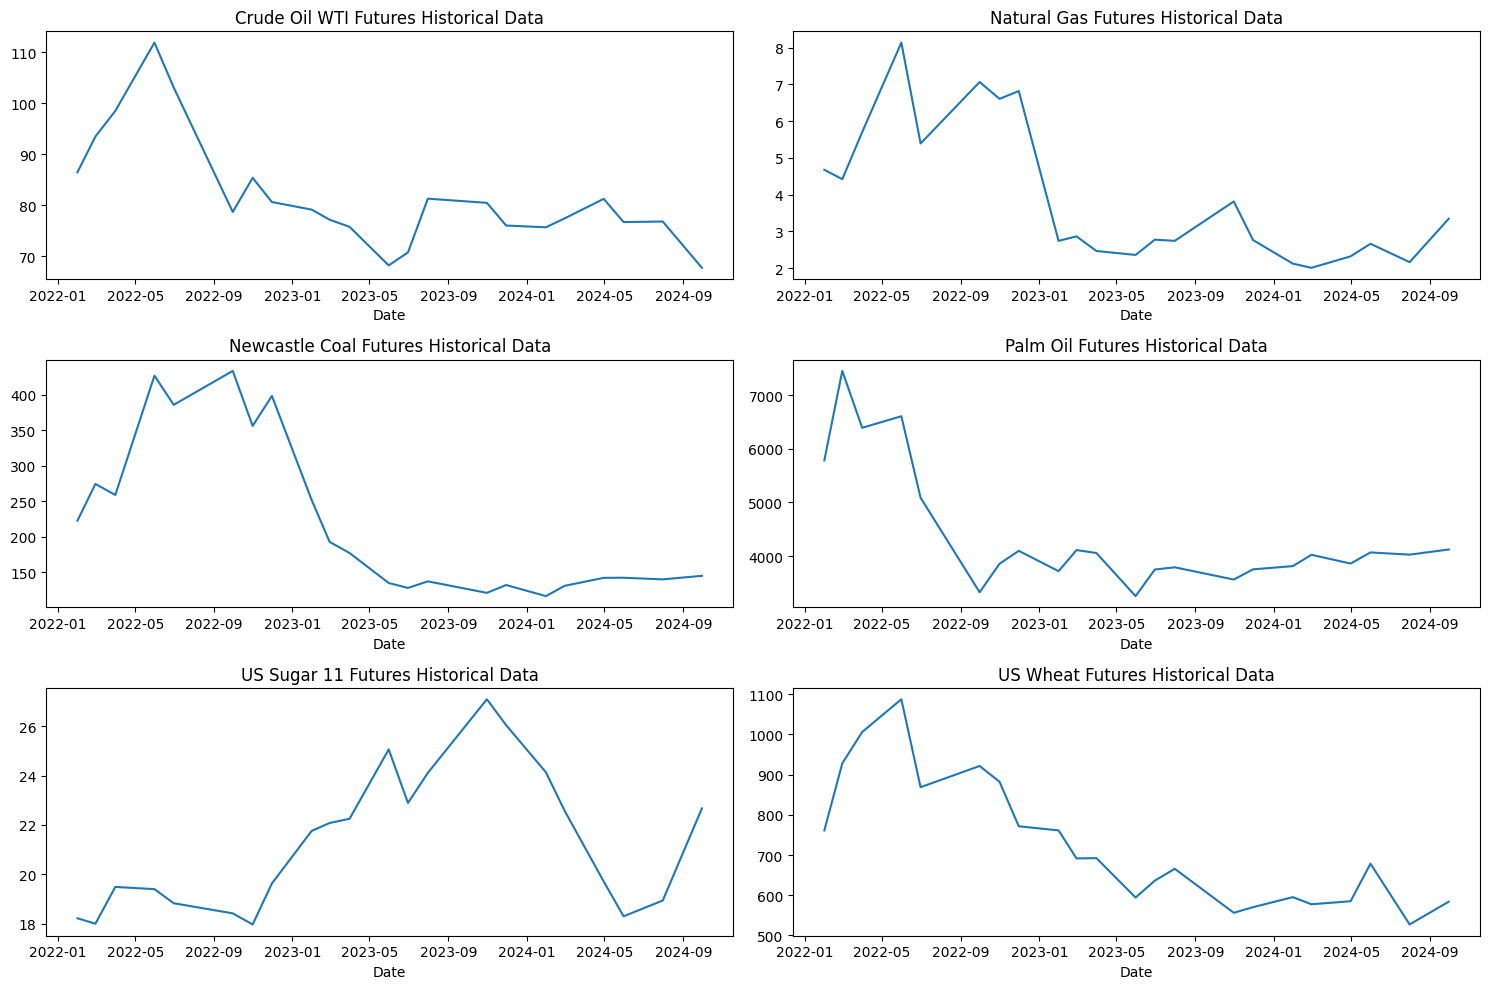

In [18]:
plt.figure(figsize=(15, 10))

for i in range(1, 7):
    plt.subplot(3, 2, i)
    sns.lineplot(commodity_df.set_index("ds").asfreq("ME"),x="ds", y=f"Com{i}")
    plt.xlabel("Date")
    plt.ylabel("")
    plt.title(f"{list(rename_commodity.keys())[i - 1]}")
    
plt.tight_layout()

In [19]:
path_exchange = "./comodity-price-prediction-penyisihan-arkavidia-9/Mata Uang/"
path_exchange_list = os.listdir(path_exchange)

exchange_list = {"MYRUSD=X" : "MYR", "SGDUSD=X" : "SGD", "THUSD=X" : "THB", "USDIDR=X" : "IDR"}

exchange_df = [pd.read_csv(path_exchange + path)[["Date","Adj Close"]].sort_values("Date") for path in path_exchange_list]

for i, df_exchange in enumerate(exchange_df):
    exchange_name = path_exchange_list[i].replace(".csv", "")
    exchange_df[i] = df_exchange.rename(columns={"Adj Close" : exchange_name})
    if i > 0:
        exchange_df[i] = exchange_df[i].drop(columns=["Date"])
    
df_exchange = pd.concat(exchange_df, axis=1)
df_exchange = df_exchange.rename(columns=exchange_list)
df_exchange = df_exchange.rename(columns={"Date":"ds"})
df_exchange["ds"] = pd.to_datetime(df_exchange["ds"])
df_exchange

ds       MYR  THBUSD=X           IDR       SGD
0   2022-01-03  0.239521  0.030201  14215.000000  0.741730
1   2022-01-04  0.239808  0.030082  14283.599609  0.739033
2   2022-01-05  0.239006  0.030083  14385.500000  0.737621
3   2022-01-06  0.238550  0.030077  14446.500000  0.736534
4   2022-01-07  0.237473  0.029804  14408.000000  0.734786
..         ...       ...       ...           ...       ...
711 2024-09-24  0.238067  0.030377  15174.099609  0.774647
712 2024-09-25  0.240964  0.030710  15121.099609  0.779812
713 2024-09-26  0.242219  0.030516  15201.500000  0.775326
714 2024-09-27  0.241546  0.030897  15070.000000  0.778889
715 2024-09-30  0.242777  0.030912  15118.000000  0.780823

[716 rows x 5 columns]

### NBEATSx Model

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MAPE
from neuralforecast.auto import AutoNBEATSx

In [ ]:
ypred_list = []
id_list = []
for bahan in bahan_pangan:
    print("=" * 5,bahan, "=" * 5)
    for prov in list_provinsi:
        print(prov)
        df_prov_train = df_train[df_train["Pangan"] == bahan][["ds", prov]]
        df_prov_train = df_prov_train.rename(columns={prov:"y"})
        
        val_size = int(len(df_prov_train) * 0.15)
        corr_tolerance = 0.3
        
        df_prov_train = pd.merge(df_prov_train, commodity_df, on="ds", how="left")
        df_prov_train = pd.merge(df_prov_train, df_exchange, on="ds", how="left")
        
        corr_features = df_prov_train.corr()["y"][2:]
        corr_features = corr_features[np.abs(corr_features) > corr_tolerance].index.to_list()
        corr_features.insert(0, "ds")
        corr_features.insert(1, "y")
        
        df_prov_train = df_prov_train[corr_features]
        df_prov_train = df_prov_train.set_index("ds")
        
        df_prov_train = df_prov_train.interpolate(method="time")
        df_prov_train = df_prov_train.bfill()
        df_prov_train = df_prov_train.ffill()
        df_prov_train = df_prov_train.reset_index()
        
        for ex in corr_features[2:]:     
            scaler = MinMaxScaler()
            df_prov_train[ex] = scaler.fit_transform(df_prov_train[[ex]])
    
        df_futures = pd.read_csv(path + f"test/Gula Konsumsi.csv").rename(columns={"Date":"ds"})[["ds"]]
        df_futures = pd.to_datetime(df_futures["ds"])
        df_futures = df_futures.reset_index().rename(columns={"index":"unique_id"})
        df_futures["unique_id"] = 1
            
        df_prov_train = df_prov_train.reset_index().rename(columns={"index":"unique_id"})
        df_prov_train["unique_id"] = 1
        
        model_lstm = NBEATSx(len(df_futures), input_size=val_size + 12,
                        max_steps=50
                        val_check_steps = 5,
                        hist_exog_list = corr_features[2:],
                        valid_loss=MAPE(),
                        loss=MAPE(),
                        batch_size=128)
    
        forecast = NeuralForecast(
            models=[model_lstm],
            freq="D"
        )
        
        forecast.fit(df_prov_train, val_size=val_size, verbose=False)
        ypred = forecast.predict(futr_df=df_futures, verbose=False)
        
        id_name = df_futures["ds"].apply(lambda x : f"{bahan}/{prov}/{str(x)}")
        id_list.append(np.array(id_name))
        
        ypred_list.append(np.array(ypred))


Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


===== Bawang Merah =====
Aceh


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Bali


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Banten


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Bengkulu


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


DI Yogyakarta


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


DKI Jakarta


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.7 M  | train
-------------------------------------------------------
3.7 M     Trainable params
47.0 K    Non-trainable params
3.7 M     Total params
14.911    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Gorontalo


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.7 M  | train
-------------------------------------------------------
3.7 M     Trainable params
47.0 K    Non-trainable params
3.7 M     Total params
14.911    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jambi


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.0 M  | train
-------------------------------------------------------
3.9 M     Trainable params
47.0 K    Non-trainable params
4.0 M     Total params
15.907    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.0 M  | train
-------------------------------------------------------
3.9 M     Trainable params
47.0 K    Non-trainable params
4.0 M     Total params
15.907    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kepulauan Bangka Belitung


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.7 M  | train
-------------------------------------------------------
3.7 M     Trainable params
47.0 K    Non-trainable params
3.7 M     Total params
14.911    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kepulauan Riau


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Lampung


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Maluku Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Maluku


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Nusa Tenggara Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Nusa Tenggara Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.2 M  | train
-------------------------------------------------------
4.2 M     Trainable params
47.0 K    Non-trainable params
4.2 M     Total params
16.902    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Papua Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Papua


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.7 M  | train
-------------------------------------------------------
3.7 M     Trainable params
47.0 K    Non-trainable params
3.7 M     Total params
14.911    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Riau


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.0 M  | train
-------------------------------------------------------
3.9 M     Trainable params
47.0 K    Non-trainable params
4.0 M     Total params
15.907    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.7 M  | train
-------------------------------------------------------
3.7 M     Trainable params
47.0 K    Non-trainable params
3.7 M     Total params
14.911    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.7 M  | train
-------------------------------------------------------
3.7 M     Trainable params
47.0 K    Non-trainable params
3.7 M     Total params
14.911    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Tenggara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.7 M  | train
-------------------------------------------------------
3.7 M     Trainable params
47.0 K    Non-trainable params
3.7 M     Total params
14.911    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.7 M  | train
-------------------------------------------------------
3.7 M     Trainable params
47.0 K    Non-trainable params
3.7 M     Total params
14.911    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


===== Bawang Putih Bonggol =====
Aceh


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Bali


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Banten


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Bengkulu


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


DI Yogyakarta


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


DKI Jakarta


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Gorontalo


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jambi


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kepulauan Bangka Belitung


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kepulauan Riau


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Lampung


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Maluku Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Maluku


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Nusa Tenggara Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Nusa Tenggara Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.5 M  | train
-------------------------------------------------------
5.4 M     Trainable params
47.0 K    Non-trainable params
5.5 M     Total params
21.879    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Papua Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Papua


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Riau


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Sulawesi Selatan


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.5 M  | train
-------------------------------------------------------
5.4 M     Trainable params
47.0 K    Non-trainable params
5.5 M     Total params
21.879    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Tenggara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.5 M  | train
-------------------------------------------------------
5.4 M     Trainable params
47.0 K    Non-trainable params
5.5 M     Total params
21.879    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


===== Beras Medium =====
Aceh


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Bali


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Banten


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Bengkulu


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


DI Yogyakarta


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


DKI Jakarta


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Gorontalo


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jambi


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.5 M  | train
-------------------------------------------------------
5.4 M     Trainable params
47.0 K    Non-trainable params
5.5 M     Total params
21.879    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.5 M  | train
-------------------------------------------------------
5.4 M     Trainable params
47.0 K    Non-trainable params
5.5 M     Total params
21.879    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.5 M  | train
-------------------------------------------------------
5.4 M     Trainable params
47.0 K    Non-trainable params
5.5 M     Total params
21.879    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kepulauan Bangka Belitung


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.0 M  | train
-------------------------------------------------------
3.9 M     Trainable params
47.0 K    Non-trainable params
4.0 M     Total params
15.907    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kepulauan Riau


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Lampung


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Maluku Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.5 M  | train
-------------------------------------------------------
5.4 M     Trainable params
47.0 K    Non-trainable params
5.5 M     Total params
21.879    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Maluku


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Nusa Tenggara Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Nusa Tenggara Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Papua Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Papua


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.7 M  | train
-------------------------------------------------------
3.7 M     Trainable params
47.0 K    Non-trainable params
3.7 M     Total params
14.911    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Riau


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.5 M  | train
-------------------------------------------------------
5.4 M     Trainable params
47.0 K    Non-trainable params
5.5 M     Total params
21.879    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Tenggara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.5 M  | train
-------------------------------------------------------
5.4 M     Trainable params
47.0 K    Non-trainable params
5.5 M     Total params
21.879    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


===== Beras Premium =====
Aceh


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Bali


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Banten


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.5 M  | train
-------------------------------------------------------
5.4 M     Trainable params
47.0 K    Non-trainable params
5.5 M     Total params
21.879    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Bengkulu


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


DI Yogyakarta


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


DKI Jakarta


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Gorontalo


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jambi


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.5 M  | train
-------------------------------------------------------
5.4 M     Trainable params
47.0 K    Non-trainable params
5.5 M     Total params
21.879    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.5 M  | train
-------------------------------------------------------
5.4 M     Trainable params
47.0 K    Non-trainable params
5.5 M     Total params
21.879    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.5 M  | train
-------------------------------------------------------
5.4 M     Trainable params
47.0 K    Non-trainable params
5.5 M     Total params
21.879    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.5 M  | train
-------------------------------------------------------
5.4 M     Trainable params
47.0 K    Non-trainable params
5.5 M     Total params
21.879    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kepulauan Bangka Belitung


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kepulauan Riau


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.5 M  | train
-------------------------------------------------------
5.4 M     Trainable params
47.0 K    Non-trainable params
5.5 M     Total params
21.879    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Lampung


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Maluku Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Maluku


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Nusa Tenggara Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Nusa Tenggara Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Papua Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Papua


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.2 M  | train
-------------------------------------------------------
4.2 M     Trainable params
47.0 K    Non-trainable params
4.2 M     Total params
16.902    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Riau


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.5 M  | train
-------------------------------------------------------
5.4 M     Trainable params
47.0 K    Non-trainable params
5.5 M     Total params
21.879    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Tenggara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.5 M  | train
-------------------------------------------------------
5.4 M     Trainable params
47.0 K    Non-trainable params
5.5 M     Total params
21.879    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.5 M  | train
-------------------------------------------------------
5.4 M     Trainable params
47.0 K    Non-trainable params
5.5 M     Total params
21.879    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.2 M  | train
-------------------------------------------------------
4.2 M     Trainable params
47.0 K    Non-trainable params
4.2 M     Total params
16.902    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


===== Cabai Merah Keriting =====
Aceh


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Bali


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Banten


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Bengkulu


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


DI Yogyakarta


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


DKI Jakarta


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Gorontalo


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jambi


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.7 M  | train
-------------------------------------------------------
3.7 M     Trainable params
47.0 K    Non-trainable params
3.7 M     Total params
14.911    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.2 M  | train
-------------------------------------------------------
4.2 M     Trainable params
47.0 K    Non-trainable params
4.2 M     Total params
16.902    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kepulauan Bangka Belitung


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.0 M  | train
-------------------------------------------------------
3.9 M     Trainable params
47.0 K    Non-trainable params
4.0 M     Total params
15.907    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kepulauan Riau


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Lampung


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Maluku Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Maluku


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Nusa Tenggara Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Nusa Tenggara Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Papua Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Papua


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Riau


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Tenggara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.2 M  | train
-------------------------------------------------------
4.2 M     Trainable params
47.0 K    Non-trainable params
4.2 M     Total params
16.902    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


===== Cabai Rawit Merah =====
Aceh


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Bali


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Banten


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Bengkulu


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


DI Yogyakarta


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


DKI Jakarta


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Gorontalo


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jambi


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.0 M  | train
-------------------------------------------------------
3.9 M     Trainable params
47.0 K    Non-trainable params
4.0 M     Total params
15.907    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kepulauan Bangka Belitung


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.7 M  | train
-------------------------------------------------------
3.7 M     Trainable params
47.0 K    Non-trainable params
3.7 M     Total params
14.911    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kepulauan Riau


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Lampung


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Maluku Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Maluku


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Nusa Tenggara Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Nusa Tenggara Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Papua Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Papua


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Riau


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Tenggara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.7 M  | train
-------------------------------------------------------
3.7 M     Trainable params
47.0 K    Non-trainable params
3.7 M     Total params
14.911    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


===== Daging Ayam Ras =====
Aceh


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Bali


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Banten


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Bengkulu


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


DI Yogyakarta


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


DKI Jakarta


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Gorontalo


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jambi


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kepulauan Bangka Belitung


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kepulauan Riau


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Lampung


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Maluku Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.2 M  | train
-------------------------------------------------------
4.2 M     Trainable params
47.0 K    Non-trainable params
4.2 M     Total params
16.902    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Maluku


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Nusa Tenggara Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.2 M  | train
-------------------------------------------------------
4.2 M     Trainable params
47.0 K    Non-trainable params
4.2 M     Total params
16.902    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Nusa Tenggara Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Papua Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Papua


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Riau


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.7 M  | train
-------------------------------------------------------
3.7 M     Trainable params
47.0 K    Non-trainable params
3.7 M     Total params
14.911    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.7 M  | train
-------------------------------------------------------
3.7 M     Trainable params
47.0 K    Non-trainable params
3.7 M     Total params
14.911    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Tenggara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
2.9 M     Trainable params
47.0 K    Non-trainable params
3.0 M     Total params
11.925    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


===== Daging Sapi Murni =====
Aceh


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Bali


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Banten


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.2 M  | train
-------------------------------------------------------
4.2 M     Trainable params
47.0 K    Non-trainable params
4.2 M     Total params
16.902    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Bengkulu


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


DI Yogyakarta


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


DKI Jakarta


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.0 M  | train
-------------------------------------------------------
3.9 M     Trainable params
47.0 K    Non-trainable params
4.0 M     Total params
15.907    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Gorontalo


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.7 M  | train
-------------------------------------------------------
3.7 M     Trainable params
47.0 K    Non-trainable params
3.7 M     Total params
14.911    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jambi


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.5 M  | train
-------------------------------------------------------
5.4 M     Trainable params
47.0 K    Non-trainable params
5.5 M     Total params
21.879    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.5 M  | train
-------------------------------------------------------
5.4 M     Trainable params
47.0 K    Non-trainable params
5.5 M     Total params
21.879    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kepulauan Bangka Belitung


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kepulauan Riau


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Lampung


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Maluku Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.7 M  | train
-------------------------------------------------------
3.7 M     Trainable params
47.0 K    Non-trainable params
3.7 M     Total params
14.911    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Maluku


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.0 M  | train
-------------------------------------------------------
3.9 M     Trainable params
47.0 K    Non-trainable params
4.0 M     Total params
15.907    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Nusa Tenggara Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Nusa Tenggara Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Papua Barat



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Papua


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.0 M  | train
-------------------------------------------------------
3.9 M     Trainable params
47.0 K    Non-trainable params
4.0 M     Total params
15.907    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Riau


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.0 M  | train
-------------------------------------------------------
3.9 M     Trainable params
47.0 K    Non-trainable params
4.0 M     Total params
15.907    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Tenggara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


===== Gula Konsumsi =====
Aceh


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Bali


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Banten


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Bengkulu


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


DI Yogyakarta


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


DKI Jakarta


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Gorontalo


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jambi


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Jawa Timur



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kepulauan Bangka Belitung


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.5 M  | train
-------------------------------------------------------
5.4 M     Trainable params
47.0 K    Non-trainable params
5.5 M     Total params
21.879    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kepulauan Riau


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Lampung


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Maluku Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Maluku


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Nusa Tenggara Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Nusa Tenggara Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Papua Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Papua


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Riau


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sulawesi Barat



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Tenggara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.2 M  | train
-------------------------------------------------------
4.2 M     Trainable params
47.0 K    Non-trainable params
4.2 M     Total params
16.902    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


===== Minyak Goreng Curah =====
Aceh


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Bali


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.2 M  | train
-------------------------------------------------------
4.2 M     Trainable params
47.0 K    Non-trainable params
4.2 M     Total params
16.902    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Banten


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Bengkulu


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.2 M  | train
-------------------------------------------------------
4.2 M     Trainable params
47.0 K    Non-trainable params
4.2 M     Total params
16.902    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


DI Yogyakarta


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


DKI Jakarta


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Gorontalo


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jambi


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.2 M  | train
-------------------------------------------------------
4.2 M     Trainable params
47.0 K    Non-trainable params
4.2 M     Total params
16.902    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.0 M  | train
-------------------------------------------------------
3.9 M     Trainable params
47.0 K    Non-trainable params
4.0 M     Total params
15.907    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kepulauan Bangka Belitung


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kepulauan Riau


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Lampung


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Maluku Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.2 M  | train
-------------------------------------------------------
4.2 M     Trainable params
47.0 K    Non-trainable params
4.2 M     Total params
16.902    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Maluku


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Nusa Tenggara Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.0 M  | train
-------------------------------------------------------
3.9 M     Trainable params
47.0 K    Non-trainable params
4.0 M     Total params
15.907    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Nusa Tenggara Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Papua Barat



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.2 M  | train
-------------------------------------------------------
4.2 M     Trainable params
47.0 K    Non-trainable params
4.2 M     Total params
16.902    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Papua


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Riau


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Tenggara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Sumatera Utara


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.2 M  | train
-------------------------------------------------------
4.2 M     Trainable params
47.0 K    Non-trainable params
4.2 M     Total params
16.902    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


===== Minyak Goreng Kemasan Sederhana =====
Aceh


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Bali


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Banten


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Bengkulu


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


DI Yogyakarta


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


DKI Jakarta


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.2 M  | train
-------------------------------------------------------
4.2 M     Trainable params
47.0 K    Non-trainable params
4.2 M     Total params
16.902    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Gorontalo


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jambi


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Kalimantan Timur



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kepulauan Bangka Belitung


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kepulauan Riau


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Lampung



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Maluku Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Maluku


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Nusa Tenggara Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Nusa Tenggara Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.2 M  | train
-------------------------------------------------------
4.2 M     Trainable params
47.0 K    Non-trainable params
4.2 M     Total params
16.902    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Papua Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Papua


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Riau


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Tenggara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


===== Telur Ayam Ras =====
Aceh


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.5 M  | train
-------------------------------------------------------
5.4 M     Trainable params
47.0 K    Non-trainable params
5.5 M     Total params
21.879    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Bali


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Banten


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Bengkulu


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.0 M  | train
-------------------------------------------------------
3.9 M     Trainable params
47.0 K    Non-trainable params
4.0 M     Total params
15.907    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


DI Yogyakarta


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.2 M  | train
-------------------------------------------------------
4.2 M     Trainable params
47.0 K    Non-trainable params
4.2 M     Total params
16.902    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


DKI Jakarta


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Gorontalo


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jambi


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.2 M  | train
-------------------------------------------------------
4.2 M     Trainable params
47.0 K    Non-trainable params
4.2 M     Total params
16.902    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.2 M  | train
-------------------------------------------------------
4.2 M     Trainable params
47.0 K    Non-trainable params
4.2 M     Total params
16.902    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.5 M  | train
-------------------------------------------------------
5.4 M     Trainable params
47.0 K    Non-trainable params
5.5 M     Total params
21.879    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Kalimantan Timur



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kepulauan Bangka Belitung


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kepulauan Riau


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Lampung


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Maluku Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Maluku



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.5 M  | train
-------------------------------------------------------
5.4 M     Trainable params
47.0 K    Non-trainable params
5.5 M     Total params
21.879    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Nusa Tenggara Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Nusa Tenggara Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Papua Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Papua


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Riau


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Tenggara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


===== Tepung Terigu (Curah) =====
Aceh


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Bali


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.0 M  | train
-------------------------------------------------------
3.9 M     Trainable params
47.0 K    Non-trainable params
4.0 M     Total params
15.907    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Banten


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Bengkulu


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


DI Yogyakarta


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


DKI Jakarta


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Gorontalo


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jambi


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.5 M  | train
-------------------------------------------------------
5.4 M     Trainable params
47.0 K    Non-trainable params
5.5 M     Total params
21.879    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Jawa Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.0 M  | train
-------------------------------------------------------
3.9 M     Trainable params
47.0 K    Non-trainable params
4.0 M     Total params
15.907    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kalimantan Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.0 M  | train
-------------------------------------------------------
3.9 M     Trainable params
47.0 K    Non-trainable params
4.0 M     Total params
15.907    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kepulauan Bangka Belitung


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.7 M  | train
-------------------------------------------------------
3.7 M     Trainable params
47.0 K    Non-trainable params
3.7 M     Total params
14.911    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Kepulauan Riau


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.5 M  | train
-------------------------------------------------------
5.4 M     Trainable params
47.0 K    Non-trainable params
5.5 M     Total params
21.879    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Lampung


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Maluku Utara



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Maluku


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.0 M  | train
-------------------------------------------------------
3.9 M     Trainable params
47.0 K    Non-trainable params
4.0 M     Total params
15.907    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Nusa Tenggara Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Nusa Tenggara Timur


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.2 M  | train
-------------------------------------------------------
5.2 M     Trainable params
47.0 K    Non-trainable params
5.2 M     Total params
20.883    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Papua Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.0 M  | train
-------------------------------------------------------
4.9 M     Trainable params
47.0 K    Non-trainable params
5.0 M     Total params
19.888    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Papua


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Riau


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.0 M  | train
-------------------------------------------------------
3.9 M     Trainable params
47.0 K    Non-trainable params
4.0 M     Total params
15.907    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.7 M  | train
-------------------------------------------------------
4.7 M     Trainable params
47.0 K    Non-trainable params
4.7 M     Total params
18.893    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.7 M  | train
-------------------------------------------------------
3.7 M     Trainable params
47.0 K    Non-trainable params
3.7 M     Total params
14.911    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Tengah


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.5 M  | train
-------------------------------------------------------
3.4 M     Trainable params
47.0 K    Non-trainable params
3.5 M     Total params
13.916    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Tenggara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
47.0 K    Non-trainable params
3.2 M     Total params
12.921    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sulawesi Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.5 M  | train
-------------------------------------------------------
4.4 M     Trainable params
47.0 K    Non-trainable params
4.5 M     Total params
17.897    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Barat


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 4.0 M  | train
-------------------------------------------------------
3.9 M     Trainable params
47.0 K    Non-trainable params
4.0 M     Total params
15.907    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Selatan


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 5.5 M  | train
-------------------------------------------------------
5.4 M     Trainable params
47.0 K    Non-trainable params
5.5 M     Total params
21.879    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sumatera Utara


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
np_id_list = np.array(id_list).reshape(-1,)
np_pred_list = np.array(ypred_list)[:, :, 2].reshape(-1,)

df_pred = pd.DataFrame(data={"id":np_id_list, "price":np_pred_list})
df_pred["id"] = df_pred["id"].replace({"00:00:00" : ""}, regex=True)
df_pred.to_csv("submissionWithNBEATSx.csv", index=False)